# Project 1: Gradient-based Algorithms and Differentiable Programming


## 1. Introduction
Consider a simple formulation of rocket landing where the rocket state $x(t)$ is represented by its distance to the ground $d(t)$ and its velocity $v(t)$, i.e., $x(t) = [d(t), v(t)]^T$, where $t$ specifies time. The control input of the rocket is its acceleration $a(t)$. The discrete-time dynamics follows 

$$
\begin{aligned}
d(t+1) = d(t) + v(t) \Delta t, \\
v(t+1) = v(t) + a(t) \Delta t,
\end{aligned}
$$

where $\Delta t$ is a time interval. Further, let the closed-loop controller be 

$$
a(t) = f_{\theta}(x(t))
$$

where $f_{\theta}(\cdot)$ is a neural network with parameters $\theta$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$. This loss encourages the rocket to reach $d(T)=0$ and $v(T)=0$, which are proper landing conditions.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{\theta} \quad & ||x(T)||^2 \\
\quad & d(t+1) = d(t) + v(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $x(T-1) and a(T-1)$, where $x(T-1)$ as a function of $x(T-2)$ and $a(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $\theta$. 

In the following, we code this problem up with [PyTorch](https://pytorch.org/), which allows us to only build the forward pass of the loss (i.e., how we move from $x(1)$ to $x(2)$ and all the way to $x(T)$) and automatically get the gradient $\nabla_{\theta} l(x(T),a(T))$.

Simple code for drag constraint.

In [169]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [170]:
# environment parameters

FRAME_TIME = 0.01  # time interval
GRAVITY_ACCEL = 9.81  # gravity constant
BOOST_ACCEL = 15.0  # thrust constant
#drag = 0.5
    
""" 
    Drag calculation
    D = Cd * A * 0.5 * r * V**2 
    assume Cd = 0.3
    A = 4 m**2
    r = 850 kg/m**3 for steel
    V = delta_state
    m = 50000 Kg
    force equilibrium 
    m * D_decel = D
    D_decel = 0.00658 * delta_state**2 
"""
# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

' \n    Drag calculation\n    D = Cd * A * 0.5 * r * V**2 \n    assume Cd = 0.3\n    A = 4 m**2\n    r = 850 kg/m**3 for steel\n    V = delta_state\n    m = 50000 Kg\n    force equilibrium \n    m * D_decel = D\n    D_decel = 0.00658 * delta_state**2 \n'

In [171]:
# define system dynamics

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):
        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        state[2] = x
        state[3] = x_dot
        """

# Initialize a matrix for new delta states
#         delta_state_mat = []
#         for i in range(len(state)):

            #gravity
#             delta_state_gravity = t.tensor([0., GRAVITY_ACCEL*FRAME_TIME, 0., 0.])

            #Drag
#             delta_state_drag = t.tensor([0.,0.,0.,-drag * FRAME_TIME])

            # thrust
#             delta_state_thrust = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0., 1., 1.]) * t.cat((t.zeros(2), action[i]))


#             delta_state = delta_state_thrust + delta_state_drag + delta_state_gravity
#             delta_state_mat.append(delta_state)
#         delta_state_mat_ten = t.stack(delta_state_mat)

        #Velocity
#         state = state + delta_state_mat_ten

#         gravity
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME, 0., 0.])
        
        delta_state_y = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action[0]
        
        delta_state_x = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., 1.]) * action[1]
        
        temp = delta_state_y
        
#         """ 
#         Drag calculation
#         D = Cd * A * 0.5 * r * V^2 
#         assume Cd = 0.3
#         A = 4 m**2
#         r = 850 kg/m**3 for steel
#         V = delta_state
#         m = 60000 Kg
#         force equilibrium 
#         m * D_decel = D
#         D_decel = 0.00658 * delta_state**2 
#         """
        
        D_decel = 0.00658 * temp * temp
        
        Net_Accel = BOOST_ACCEL - D_decel
        
        delta_state_y = Net_Accel * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action[0]
        
        state = state + delta_state_y + delta_state_gravity + delta_state_x
        #Position
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.],
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]])

        
        state = t.matmul(step_mat, state)

        return state
#         print(type(state))

In [172]:
# a deterministic controller

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: # up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [173]:
# the simulator that rolls out x(1), x(2), ..., x(T)

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        
        state = [1, 0., 0., 0.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2

In [178]:
# set up the optimizer

# loss = []
lossplt = []
# losspltarr = []
class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward() # need to go through this part
#             lossplt.append(loss.backward())
            return loss
#             return lossplt
#         lossplt = []
#         lossplt.append(loss)
        self.optimizer.step(closure) # need to go through this
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            lossplt.append(loss)
#             losspltarr = lossplt.numpy()
            print('\n Itr:\t',epoch + 1)
            print('loss: %.3f' % (loss))
#             lossplt = []
#             lossplt.append(loss)
            self.visualize()
#         return lossplt()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        a = data[:, 2]
        b = data[:, 3]
        c = data[:, 2]
        d = data[:, 0]
        
        plt.figure()
        plt.subplot(221)
        plt.plot(x, y)
        
        plt.subplot(222)
        plt.plot(a, b)
        
        plt.subplot(223)
        plt.plot(c, d)
        plt.tight_layout()
        plt.show()
        

# plt.plot(lossplt)
# plt.show()


 Itr:	 1
loss: 29.526


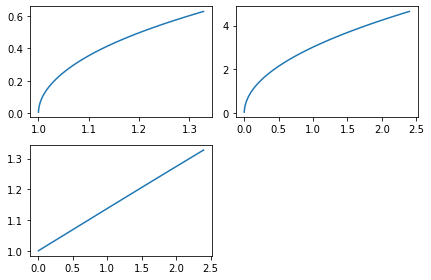


 Itr:	 2
loss: 15.827


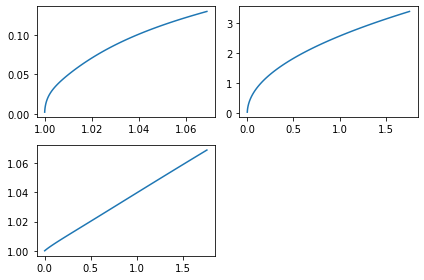


 Itr:	 3
loss: 9.469


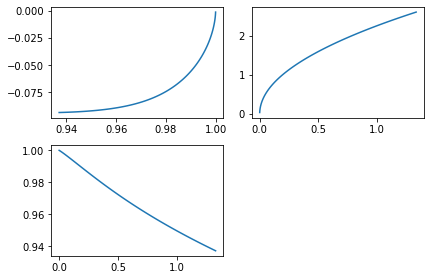


 Itr:	 4
loss: 5.483


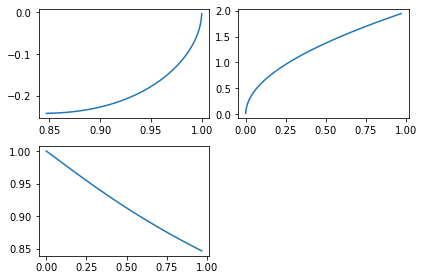


 Itr:	 5
loss: 3.747


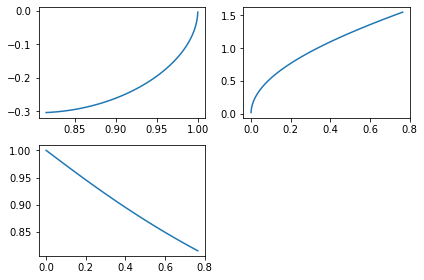


 Itr:	 6
loss: 2.711


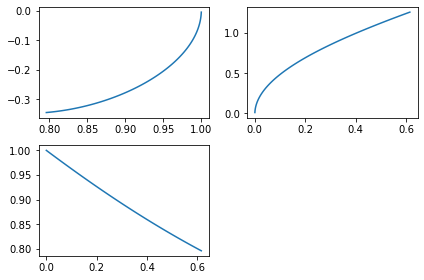


 Itr:	 7
loss: 2.028


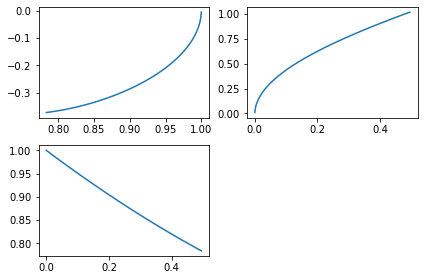


 Itr:	 8
loss: 1.622


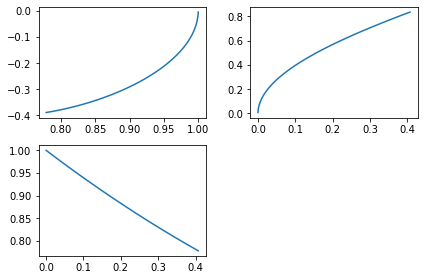


 Itr:	 9
loss: 1.369


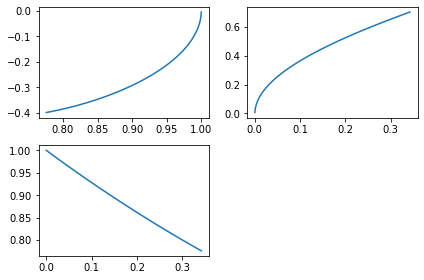


 Itr:	 10
loss: 1.203


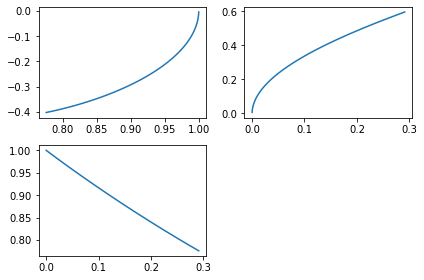


 Itr:	 11
loss: 1.081


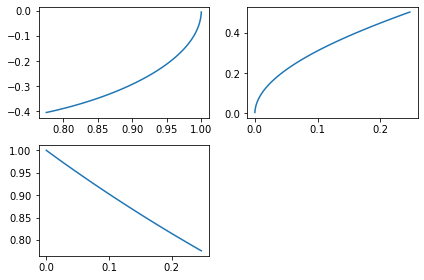


 Itr:	 12
loss: 0.979


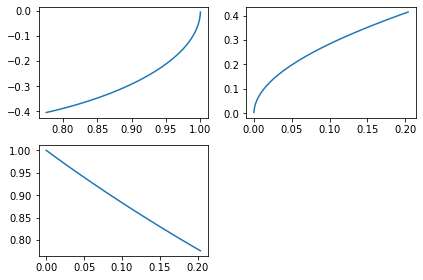


 Itr:	 13
loss: 0.895


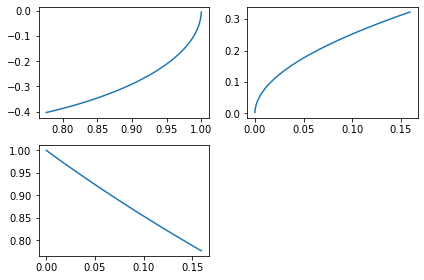


 Itr:	 14
loss: 0.845


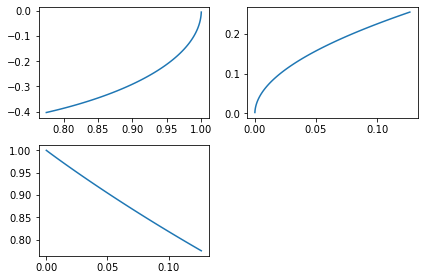


 Itr:	 15
loss: 0.785


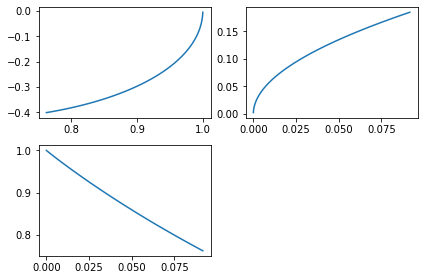


 Itr:	 16
loss: 0.684


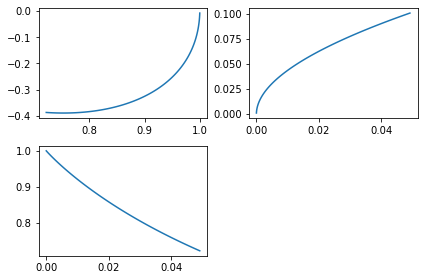


 Itr:	 17
loss: 0.501


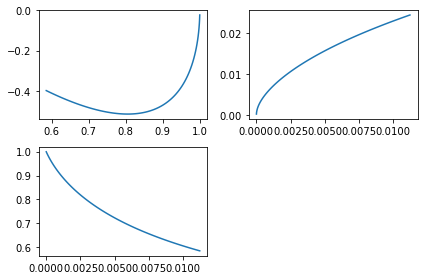


 Itr:	 18
loss: 0.054


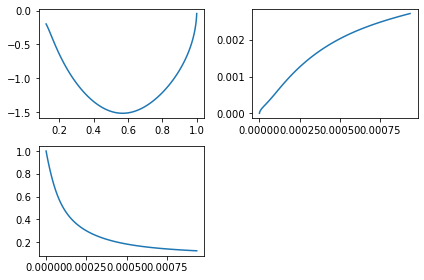


 Itr:	 19
loss: 0.016


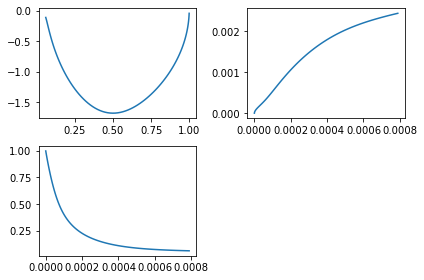


 Itr:	 20
loss: 0.008


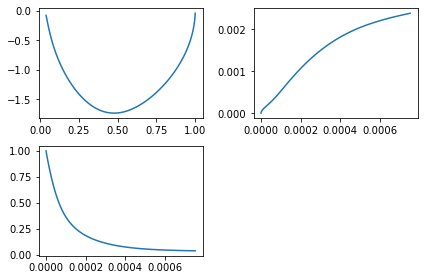


 Itr:	 21
loss: 0.004


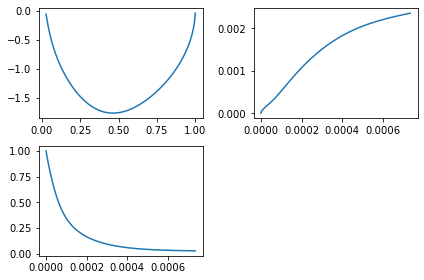


 Itr:	 22
loss: 0.003


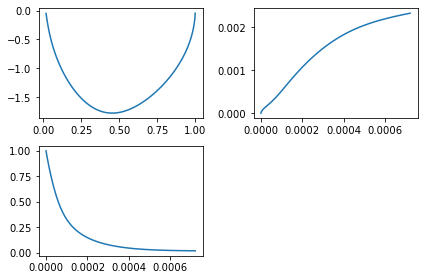


 Itr:	 23
loss: 0.002


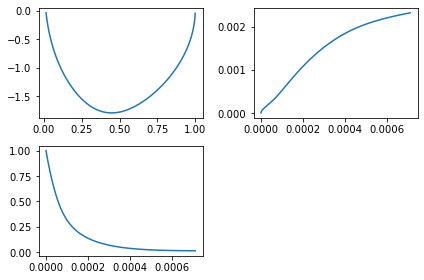


 Itr:	 24
loss: 0.001


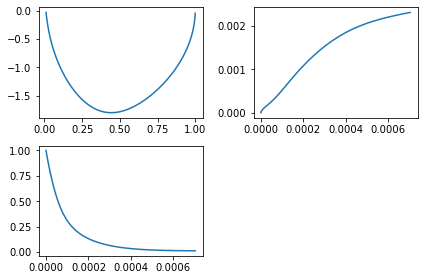


 Itr:	 25
loss: 0.001


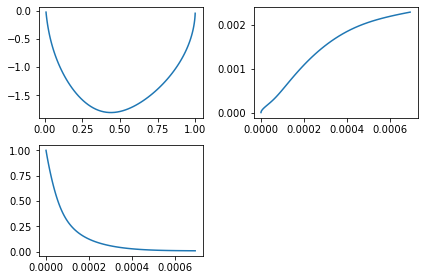


 Itr:	 26
loss: 0.000


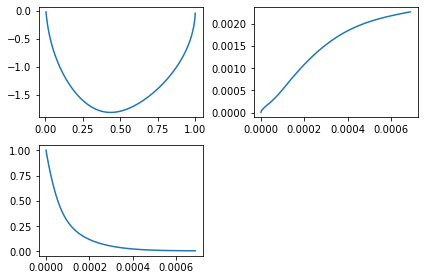


 Itr:	 27
loss: 0.000


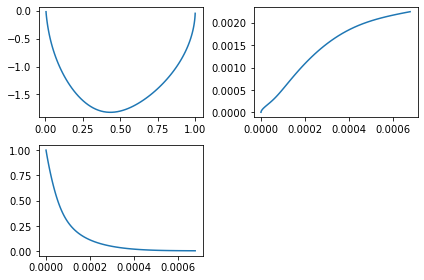


 Itr:	 28
loss: 0.000


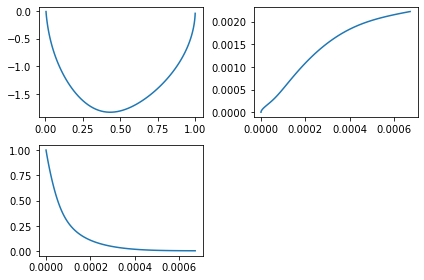


 Itr:	 29
loss: 0.000


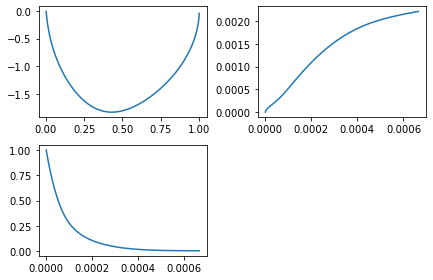


 Itr:	 30
loss: 0.000


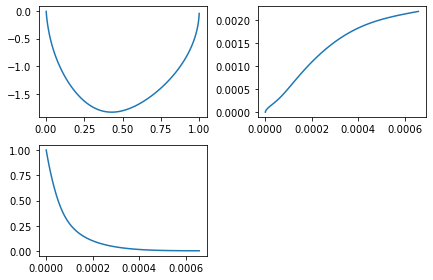


 Itr:	 31
loss: 0.000


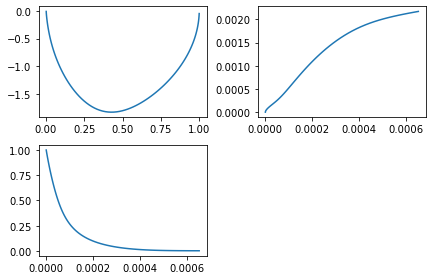


 Itr:	 32
loss: 0.000


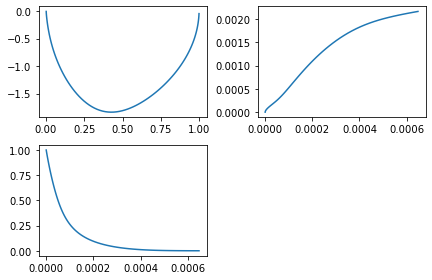


 Itr:	 33
loss: 0.000


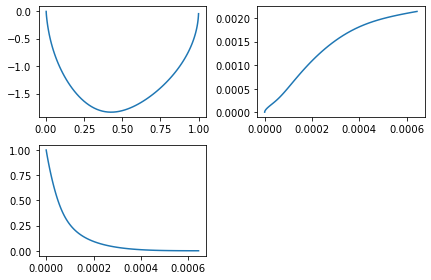


 Itr:	 34
loss: 0.000


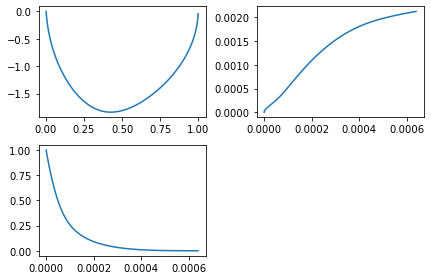


 Itr:	 35
loss: 0.000


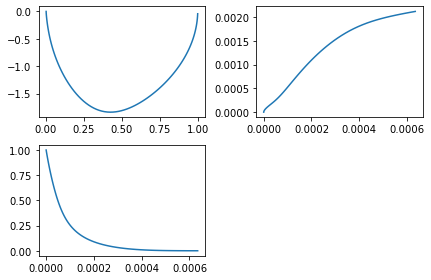


 Itr:	 36
loss: 0.000


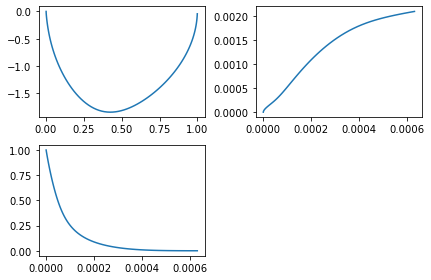


 Itr:	 37
loss: 0.000


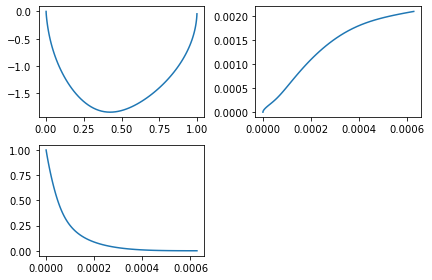


 Itr:	 38
loss: 0.000


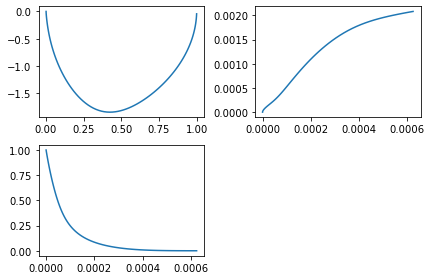


 Itr:	 39
loss: 0.000


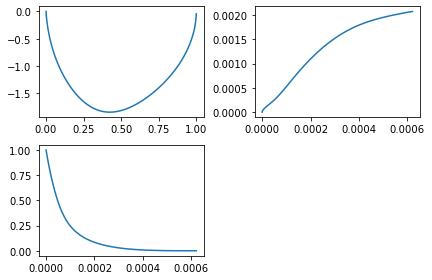


 Itr:	 40
loss: 0.000


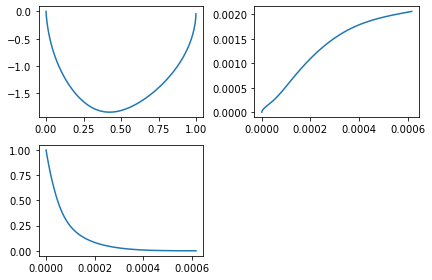

[tensor(29.5256, grad_fn=<AddBackward0>), tensor(15.8271, grad_fn=<AddBackward0>), tensor(9.4694, grad_fn=<AddBackward0>), tensor(5.4830, grad_fn=<AddBackward0>), tensor(3.7470, grad_fn=<AddBackward0>), tensor(2.7108, grad_fn=<AddBackward0>), tensor(2.0284, grad_fn=<AddBackward0>), tensor(1.6218, grad_fn=<AddBackward0>), tensor(1.3694, grad_fn=<AddBackward0>), tensor(1.2030, grad_fn=<AddBackward0>), tensor(1.0806, grad_fn=<AddBackward0>), tensor(0.9790, grad_fn=<AddBackward0>), tensor(0.8949, grad_fn=<AddBackward0>), tensor(0.8446, grad_fn=<AddBackward0>), tensor(0.7848, grad_fn=<AddBackward0>), tensor(0.6837, grad_fn=<AddBackward0>), tensor(0.5011, grad_fn=<AddBackward0>), tensor(0.0543, grad_fn=<AddBackward0>), tensor(0.0160, grad_fn=<AddBackward0>), tensor(0.0079, grad_fn=<AddBackward0>), tensor(0.0044, grad_fn=<AddBackward0>), tensor(0.0026, grad_fn=<AddBackward0>), tensor(0.0016, grad_fn=<AddBackward0>), tensor(0.0010, grad_fn=<AddBackward0>), tensor(0.0007, grad_fn=<AddBackward0>

In [179]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 4  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem
# U = t.tensor([BOOST_ACCEL*action[0], action[1]])
print(lossplt)
# print(s)
# print(type(s))
# print(d)
# print(c)

In [ ]:
# minimize for drag
import numpy

def black_func(x, y):
     return 1/(x*((1.204*v**2)/2)*y)
v = numpy.linspace(0, -0.16, num=10)
# for i in vel:
#     v = vel.append()
# print(v)
# vel = numpy.array([range(0, -0.16)])
from bayes_opt import BayesianOptimization
import numpy
# import matplotlib as plt
# from matplotlib import gridspec
# X = []
# Y = []
# itr = []
# t = []
bounds = {'x': (0.1, 0.16), 'y': (0.1, 1)}
for v in range(1, len(v)):
        
    optim = BayesianOptimization(f=black_func, pbounds=bounds, random_state=1)
    optim.maximize(init_points=2,n_iter=5)
    print(optim.max)
j = []
for i, res in enumerate(optim.res):
    for j in numpy.linspace(0, -0.16, num=10):
        
        print("velocity = ", j)
    print("Iteration {}: \n\t{}".format(i, res))